###  Imports

In this section, we import all the essential libraries needed for working with data and evaluating our model:

- **numpy** — performs numerical operations and array manipulation  
- **pandas** — handles datasets efficiently using DataFrames  
- **math** — provides mathematical functions used in probability calculations  
- **load_breast_cancer** — loads a built-in dataset for classification  
- **train_test_split** — divides the data into training and testing sets  
- **accuracy_score** — measures how well the model performs  

These libraries give us the tools for data loading, preprocessing, splitting, and performance evaluation.


In [8]:
import numpy as np
import pandas as pd
import math
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Node Class

This class represents a single node in a decision tree.  
Each node stores:

- **feature_index** — the index of the feature used for splitting at this node  
- **threshold** — the value that determines how the data is divided  
- **left** — the left child node (samples that meet the split condition)  
- **right** — the right child node (samples that do not meet the split condition)  
- **value** — the predicted class label (used only for leaf nodes)

This structure allows the model to recursively split data until a final decision is reached.



In [9]:
class Node:
    def __init__(self, feature_index, threshold, left, right, value):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

###  Modified Decision Tree Class

This version of the Decision Tree introduces important enhancements, especially support for **feature sub-sampling**, which is commonly used in Random Forests.

####  Key Components

- **max_depth** — limits how deep the tree can grow  
- **min_samples_split** — minimum number of samples required to split  
- **max_features** — *NEW*: selects a random subset of features for each split  
- **feature_importances** — tracks how much each feature contributes to reducing entropy  
- **root** — the root node of the trained tree  

####  Training the Tree (`fit`)
- Resets feature importances  
- Builds the tree recursively  
- Stores the final model inside `self.root`

####  Making Predictions (`predict`)
- Traverses the tree for each row  
- Follows left/right branches based on threshold comparisons  
- Returns the predicted label of the destination leaf

####  Building the Tree (`build_tree`)
- Computes the majority class (for stopping conditions)  
- Stops when:
  - max depth reached  
  - too few samples  
  - pure node  
- Otherwise:
  - Finds the **best split**  
  - Updates feature importance using information gain  
  - Recursively creates left and right child nodes  

####  Entropy Calculation
Uses Shannon entropy to measure disorder in labels — the core of information gain.

####  Finding the Best Split (`find_best_split`)
- Computes entropy of the current node  
- Uses **only a random subset of features** when `max_features` is set  
- For each candidate feature:
  - Sorts unique values  
  - Tries midpoints between consecutive values as thresholds  
  - Computes information gain  
- Selects the split with the highest information gain

This design makes the tree both **optimized** and **compatible with Random Forest logic** while keeping the implementation readable and modular.


In [10]:
# --- Modified Decision Tree Class ---
class DecisionTree:
    def __init__(self, max_depth, min_samples_split, max_features=None):
        self.max_depth = max_depth #Without this, the tree would keep splitting until every leaf is pure, which causes overfitting (memorizing the data)
        self.min_samples_split = min_samples_split #If a node has only 2 samples, splitting it further is likely just capturing noise. This prevents the tree from making decisions based on too little data
        self.max_features = max_features  # NEW: Store max_features ,meaning look at all features
        self.root = None
        self.feature_importances = np.zeros(30) #This array is used to track how useful each feature is. Every time a feature is chosen for a split, its "Information Gain" is added to the corresponding index in this array,30 features

    def fit(self, x, y):
        # Reset feature importances for new fit
        self.feature_importances = np.zeros(x.shape[1]) #dynamic , instead of hardcoded 30 columns
        self.root = self.build_tree(x, y, depth=0) #start building the tree from the root

    def predict(self, x):
        predictions = x.apply(lambda row: self.traverse_tree(row, self.root), axis=1) #apply function to each row of x, traversing the tree to get predictions,axis=1 means row-wise
        #x.apply It takes a function and runs it repeatedly over the dataframe ,pandas series
        return predictions.values #converts the pandas series to a numpy array for easier handling we remove the index and just get the raw values

    def build_tree(self, x, y, depth): #This function is the recursive heart of the Decision Tree. It calls itself over and over to grow the tree branch by branch
        unique_labels, counts = np.unique(y, return_counts=True)
        majority_class = unique_labels[np.argmax(counts)]

        if depth >= self.max_depth or len(y) < self.min_samples_split or len(unique_labels) == 1: #len(unique_labels) == 1 means the node is pure
            return Node(None, None, None, None, majority_class) #leaf node with majority class

        best_gain, feature_index, threshold = self.find_best_split(x, y)

        if best_gain < 1e-9: #safety check to prevent splits that don't improve the model,zero gain
            return Node(None, None, None, None, majority_class) #leaf node with majority class

        else:
            self.feature_importances[feature_index] += best_gain # Update feature importance
            feature_column = x.iloc[:, feature_index] # Get the entire column for the best feature,iloc is used to access columns by index
            filter_left = feature_column <= threshold
            
            # Create splits
            x_left, y_left = x[filter_left], y[filter_left]
            x_right, y_right = x[~filter_left], y[~filter_left] # Optimized with ~

            left_child = self.build_tree(x_left, y_left, depth + 1) # depth+1 so the next level knows we are one level deeper
            right_child = self.build_tree(x_right, y_right, depth + 1)

        return Node(feature_index, threshold, left_child, right_child, None) #return a decision node

    def traverse_tree(self, x_row, node):
        if node.value is not None:  #we have reached a leaf node
            return node.value
        
        feature_value = x_row.iloc[node.feature_index] #get the feature value for the current node's feature index,iloc to access by index
        if feature_value <= node.threshold:
            return self.traverse_tree(x_row, node.left)
        else:
            return self.traverse_tree(x_row, node.right)

    def calculate_entropy(self, y):
        
        totSamples = len(y)
        _, counts = np.unique(y, return_counts=True) # the function returns (unique_values, counts), the underscore to show we dont care about the first arg
        entropy = 0
        for count in counts:
            p_k = count / totSamples
            entropy += (-p_k * math.log2(p_k))
        return entropy

    def find_best_split(self, x, y):
        max_info_gain = -math.inf
        best_feature = None
        best_threshold = None
        totSamples = len(y)
        entropy_Y = self.calculate_entropy(y)

        # NEW LOGIC: Select Random Subset of Features  
        n_features = x.shape[1]
        
        # If max_features is set, select random indices. Otherwise, use all.
        if self.max_features and self.max_features < n_features:
            feature_indices = np.random.choice(n_features, self.max_features, replace=False) #replace False means no duplicates
        else:
            feature_indices = range(n_features)

        # Loop ONLY over the selected random subset
        for candidate_feature in feature_indices:
            feature_data = x.iloc[:, candidate_feature] #x is only date in the current node not the whole dataset
            unique_values = feature_data.unique() # Get unique values in the feature column
            sorted_unique_values = np.sort(unique_values) 

            # Optimization: Skip features with only 1 unique value , all samples have the same value for this feature
            if len(sorted_unique_values) < 2:
                continue

            for i in range(len(sorted_unique_values) - 1): #-1 because if we have n unique values we can make n-1 splits , in between the values
                candidate_threshold = (sorted_unique_values[i] + sorted_unique_values[i + 1]) / 2
                
                # Vectorized filtering is faster
                filter_left = feature_data <= candidate_threshold #[10,20,15] <= 15 -> [True, True, False]
                y_left = y[filter_left]
                y_right = y[~filter_left]

                samples_left = len(y_left)
                samples_right = len(y_right)

                if samples_left == 0 or samples_right == 0: #useless split , skip and move to the next threshold
                    continue

                entropy_left = self.calculate_entropy(y_left)
                entropy_right = self.calculate_entropy(y_right)
                
                entropy_YgivenX = (samples_left / totSamples) * entropy_left + (samples_right / totSamples) * entropy_right
                info_gain = entropy_Y - entropy_YgivenX

                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    best_feature = candidate_feature
                    best_threshold = candidate_threshold

        return max_info_gain, best_feature, best_threshold

### RandomForest Class — Explanation

The `RandomForest` class builds an ensemble of decision trees, each trained on a different random subset of the data and features. This randomness helps reduce overfitting and improves generalization.

---

#### **Key Components**

- **n_trees**  
  Number of decision trees to build in the forest.

- **max_depth**  
  Maximum depth allowed for each tree to prevent overfitting.

- **min_samples_split**  
  Minimum number of samples required to split an internal node.

- **max_features_mode**  
  Controls how many features each tree can use at each split:  
  - `'sqrt'` → use √(number of features)  
  - `'div2'` → use half of the features  
  - `'all'` → use all features  

---

### **How `fit()` Works**

1. **Determine number of features per split**  
   According to the chosen `max_features_mode`.

2. **Bootstrap sampling**  
   Each tree is trained on a random sample of the dataset *with replacement*.  
   This introduces variation across the trees.

3. **Train a DecisionTree**  
   Each tree receives  
   - a bootstrapped dataset  
   - the number of features it is allowed to consider per split  
   This creates diverse trees, which is the core of Random Forest.

4. **Store all trained trees**  
   The forest is simply a list of decision tree models.

---

### **How `predict()` Works**

1. Each tree predicts independently for all samples.  
2. Predictions from all trees are collected.  
3. **Majority voting** is applied for each sample to determine the final class.

This ensemble strategy makes the Random Forest more stable and accurate compared to a single decision tree.



In [11]:
class RandomForest:
    def __init__(self, n_trees, max_depth, min_samples_split, max_features_mode='sqrt'):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features_mode = max_features_mode #it acceepts 'sqrt' or 'div2'
        self.trees = []
    
    def fit(self, x, y):
        self.trees = []
        n_samples, n_features = x.shape
        
        # Determine number of features per split
        if self.max_features_mode == 'sqrt':
            self.max_features = int(math.sqrt(n_features))
        elif self.max_features_mode == 'div2':
            self.max_features = int(n_features / 2)
        else:
            self.max_features = n_features

        for _ in range(self.n_trees):
            # 1. Bootstrap Sampling (with replacement)
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True) #if replaace=true , all trees would have the same samples just shuffled
            x_sample = x.iloc[bootstrap_indices]
            y_sample = y.iloc[bootstrap_indices]
            
            # 2. Train Tree with Random Features
            tree = DecisionTree(
                max_depth=self.max_depth, 
                min_samples_split=self.min_samples_split,
                max_features=self.max_features 
            )
            tree.fit(x_sample, y_sample)
            self.trees.append(tree)
            
    def predict(self, x):
        # Gather predictions from all trees
        tree_preds = np.array([tree.predict(x) for tree in self.trees]).T # Transpose to have shape (n_samples, n_trees)
        
        # Majority Vote
        final_preds = []
        for row_preds in tree_preds:
            values, counts = np.unique(row_preds, return_counts=True)
            final_preds.append(values[np.argmax(counts)])
            
        return np.array(final_preds)

In [12]:
cancer = load_breast_cancer()
x = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

# Split Data (70/15/15)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Hyperparameter Tuning Loop

This loop tests different Random Forest configurations by varying:
- **T** — number of trees in the forest  
- **max_features** — how many features each split can consider  

Steps performed:
1. Loop over candidate tree counts (5, 10, 30, 50)  
2. Loop over feature selection modes (`sqrt`, `div2`)  
3. Train a Random Forest on the training set  
4. Evaluate its accuracy on the validation set  
5. Keep track of the **best performing configuration**

At the end, it prints:
- The **best parameter combination**
- The **highest validation accuracy**

This ensures you pick the most effective model before final evaluation.

Training Random Forest (Base Depth: 4, Base Min Samples: 2)...
Testing T=5, max_features=sqrt... Validation Acc: 0.8953
Testing T=5, max_features=div2... Validation Acc: 0.9070
Testing T=10, max_features=sqrt... Validation Acc: 0.9070
Testing T=10, max_features=div2... Validation Acc: 0.8953


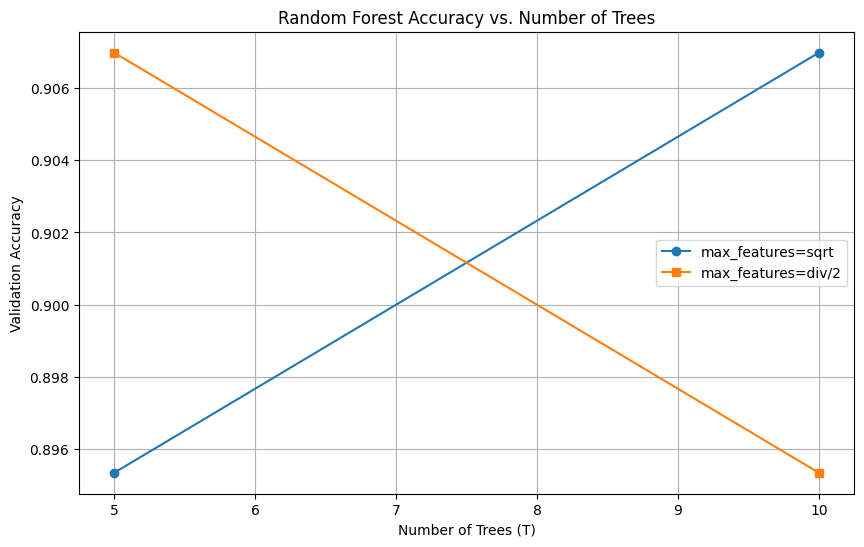


BEST CONFIGURATION: {'T': 5, 'max_features': 'div2'}
BEST VALIDATION ACCURACY: 0.9070


In [ ]:
import matplotlib.pyplot as plt
best_max_depth= 4 
best_min_samples = 2 

T_values = [5, 10,30, 50]
max_features_options = ['sqrt', 'div2']

best_val_accuracy = 0
best_rf_params = {} #dictionary to store best params

print(f"Training Random Forest (Base Depth: {best_max_depth}, Base Min Samples: {best_min_samples})...")

results_history = { 'sqrt': [], 'div2': [] }
# Tuning Loop 
for T in T_values:
    for mf in max_features_options:
        print(f"Testing T={T}, max_features={mf}...", end=" ")
        
        rf = RandomForest(
            n_trees=T, 
            max_depth=best_max_depth, 
            min_samples_split=best_min_samples, 
            max_features_mode=mf
        )
        
        rf.fit(x_train, y_train)
        val_preds = rf.predict(x_validation)
        acc = accuracy_score(y_validation, val_preds)
        
        print(f"Validation Acc: {acc:.4f}")
        results_history[mf].append(acc)

        if acc > best_val_accuracy:
            best_val_accuracy = acc
            best_rf_params = {'T': T, 'max_features': mf}

plt.figure(figsize=(10, 6))
plt.plot(T_values, results_history['sqrt'], marker='o', label='max_features=sqrt')
plt.plot(T_values, results_history['div2'], marker='s', label='max_features=div/2')

plt.title('Random Forest Accuracy vs. Number of Trees')
plt.xlabel('Number of Trees (T)')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print("\n" + "="*30)
print(f"BEST CONFIGURATION: {best_rf_params}")
print(f"BEST VALIDATION ACCURACY: {best_val_accuracy:.4f}")
print("="*30)

##  Final Evaluation on Test Set
Once the best parameters are found:
1. Combine training + validation sets  
2. Retrain the Random Forest with optimal settings  
3. Predict on the unseen test set  
4. Compute **final test accuracy**, which reflects true model performance  

This gives the final evaluation metric used to judge the whole Random Forest pipeline.

In [17]:
x_combined = pd.concat([x_train, x_validation])
y_combined = pd.concat([y_train, y_validation])

final_rf = RandomForest(
    n_trees=best_rf_params['T'],
    max_depth=best_max_depth,
    min_samples_split=best_min_samples,
    max_features_mode=best_rf_params['max_features']
)

final_rf.fit(x_combined, y_combined)
test_preds = final_rf.predict(x_test)
test_acc = accuracy_score(y_test, test_preds)

print(f"FINAL TEST ACCURACY: {test_acc:.4f}")

FINAL TEST ACCURACY: 0.9647
